In [1]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import numpy as np

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Settings and Dataset

In [2]:
## Settings

# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# hyperparameters
random_seed = 0
learning_rate = 0.05
num_epochs = 10
batch_size = 8

# architecture
num_features = 2
num_classes = 3


In [3]:
# IRIS dataset

data = np.genfromtxt('../data/iris.data', delimiter=',', dtype=str)
X, y = data[:, [2, 3]], data[:, 4]
X = X.astype(float)

d = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
y = np.array([d[x] for x in y])
y = y.astype(int)

print('Class label counts:', np.bincount(y))
print('X.shape:', X.shape)
print('y.shape:', y.shape)

# Shuffling & train/test split
shuffle_idx = np.arange(y.shape[0])
shuffle_rng = np.random.RandomState(123)
shuffle_rng.shuffle(shuffle_idx)
X, y = X[shuffle_idx], y[shuffle_idx]

X_train, X_test = X[shuffle_idx[:70]], X[shuffle_idx[70:]]
y_train, y_test = y[shuffle_idx[:70]], y[shuffle_idx[70:]]

# Normalize (mean zero, unit variance)
mu, sigma = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

Class label counts: [50 50 50]
X.shape: (150, 2)
y.shape: (150,)


In [4]:
## Data Loaders

from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class MyDataset(Dataset):

    def __init__(self, X, y):
    
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.int64)

    def __getitem__(self, index):
        training_example, training_label = self.X[index], self.y[index]
        return training_example, training_label

    def __len__(self):
        return self.y.shape[0]
    
    
train_dataset = MyDataset(X[:100], y[:100])
test_dataset = MyDataset(X[100:], y[100:])


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

In [5]:
## Model

class SoftmaxRegression(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(SoftmaxRegression, self).__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)

        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()

    def forward(self, x):
        logits = self.linear(x)
        probas = torch.softmax(logits, dim=1)
        return logits, probas

model = SoftmaxRegression(num_features=num_features,
                          num_classes=num_classes)

model.to(device)

# cost and optimizer

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
# manual seed for deterministic data loader
torch.manual_seed(random_seed)

def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0

    for features, targets in data_loader:
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()

    return correct_pred.float() / num_examples * 100

for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.to(device)
        targets = targets.to(device)

        # forward and backprop
        logits, probas = model(features)

        # note pytorch corss entropy takes in logits instead of probas
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        cost.backward()

        optimizer.step()

        # logging
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_dataset)//batch_size, cost))

    with torch.set_grad_enabled(False):
        print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader))) 

Epoch: 001/010 | Batch 000/012 | Cost: 1.0986
Epoch: 001/010 training accuracy: 33.00%
Epoch: 002/010 | Batch 000/012 | Cost: 0.8322
Epoch: 002/010 training accuracy: 72.00%
Epoch: 003/010 | Batch 000/012 | Cost: 0.8241
Epoch: 003/010 training accuracy: 75.00%
Epoch: 004/010 | Batch 000/012 | Cost: 0.5644
Epoch: 004/010 training accuracy: 93.00%
Epoch: 005/010 | Batch 000/012 | Cost: 0.6460
Epoch: 005/010 training accuracy: 72.00%
Epoch: 006/010 | Batch 000/012 | Cost: 0.6106
Epoch: 006/010 training accuracy: 88.00%
Epoch: 007/010 | Batch 000/012 | Cost: 0.5200
Epoch: 007/010 training accuracy: 81.00%
Epoch: 008/010 | Batch 000/012 | Cost: 0.5416
Epoch: 008/010 training accuracy: 93.00%
Epoch: 009/010 | Batch 000/012 | Cost: 0.4425
Epoch: 009/010 training accuracy: 81.00%
Epoch: 010/010 | Batch 000/012 | Cost: 0.3994
Epoch: 010/010 training accuracy: 78.00%


In [7]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 64.00%


## ModelWrapper for plot_decision_region

In [8]:
class ModelWrapper():
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def predict(self, X):
        features = torch.tensor(X, dtype=torch.float32, device=self.device)
        logits, probas = self.model(features)
        _, predicted_labels = torch.max(probas, 1)

        return predicted_labels.numpy()

In [9]:
mymodel = ModelWrapper(model, device=torch.device('cpu'))

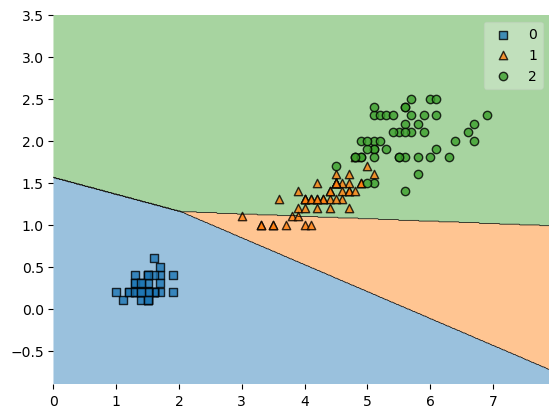

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

plot_decision_regions(X, y, mymodel)
plt.show()